In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import seaborn as sns

from math import ceil
from pathlib import Path
from sklearn.decomposition import PCA

%matplotlib inline

# Metadonnées

## Importation des DataFrame

In [15]:
# Chemin vers le dossier contenant les xlsx
folder = Path("../data")

# Lecture de DataFrames
df_covid = pd.read_excel(folder / "COVID.metadata.xlsx")
df_lung = pd.read_excel(folder / "Lung_Opacity.metadata.xlsx")
df_normal = pd.read_excel(folder / "normal.metadata.xlsx")
df_pneumonia = pd.read_excel(folder / "Viral Pneumonia.metadata.xlsx")

In [16]:
# Renommage des colonnes "PATHO" de chaque DF
df_covid["PATHO"] = "COVID"
df_lung["PATHO"] = "Lung_Opacity"
df_normal["PATHO"] = "Normal"
df_pneumonia["PATHO"] = "Viral Pneumonia"

In [17]:
# Concaténation des DF
df = pd.concat([df_covid, df_lung, df_normal, df_pneumonia], axis=0)

In [18]:
# Affichage des 5 premières lignes
df.head()

,FILE NAME,FORMAT,SIZE,URL,PATHO
0,COVID-1,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
1,COVID-2,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
2,COVID-3,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
3,COVID-4,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID
4,COVID-5,PNG,256*256,https://sirm.org/category/senza-categoria/covi...,COVID


In [19]:
# Recherche de duplicats
df.duplicated().any()

False

## Countplot

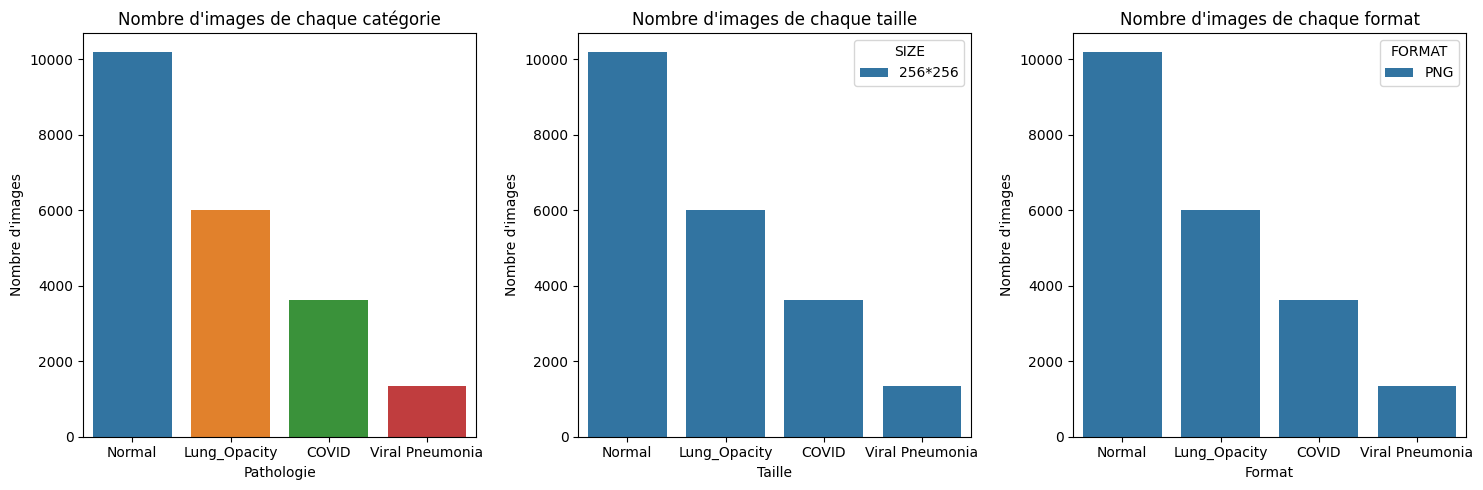

In [20]:
# Initialisation de la  figure avec une grille de sous-graphiques avec 1 ligne et 3 colonnes
fig, axes = plt.subplots(nrows=1,
                         ncols=3,
                         figsize=(15, 5))

# Premier countplot
sns.countplot(x="PATHO", data=df, order=df["PATHO"].value_counts().index, ax=axes[0])
axes[0].set_xlabel("Pathologie")
axes[0].set_ylabel("Nombre d'images")
axes[0].set_title("Nombre d'images de chaque catégorie")

# Deuxième countplot
sns.countplot(x="PATHO", hue="SIZE", data=df, order=df["PATHO"].value_counts().index, ax=axes[1])
axes[1].set_xlabel("Taille")
axes[1].set_ylabel("Nombre d'images")
axes[1].set_title("Nombre d'images de chaque taille")

# Troisième countplot
sns.countplot(x="PATHO", hue="FORMAT", data=df, order=df["PATHO"].value_counts().index, ax=axes[2])
axes[2].set_xlabel("Format")
axes[2].set_ylabel("Nombre d'images")
axes[2].set_title("Nombre d'images de chaque format")

# Ajustez les espacements entre les sous-graphiques
plt.tight_layout()

# Affichez la figure avec les countplots
plt.show()


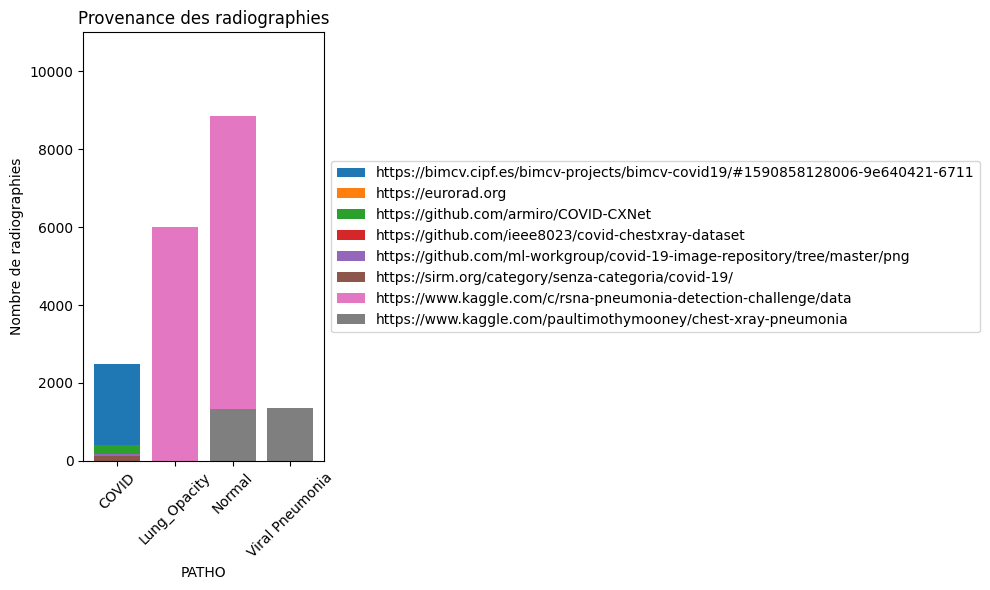

In [38]:
# Grouper les données par "URL" et "PATHO", puis compter les occurrences
occurrences = df.groupby(["URL", "PATHO"]).size().reset_index(name="Occurrence")

# Créer un graphique à barres pour visualiser les résultats
plt.figure(figsize=(10, 6))
for url, group in occurrences.groupby("URL"):
    plt.bar(group["PATHO"], group["Occurrence"], label=url)

plt.xlabel("PATHO")
plt.ylabel("Nombre de radiographies")
plt.ylim(0, 11000)
plt.title("Provenance des radiographies")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))  # Place la légende à droite du graphique
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Images

## Chemins

In [2]:
# Chemin du dossier dans lequel se trouvent les dossiers d'images
folder = Path("../data")

# Noms des sous-dossiers contenant les images
subfolders = [
    "COVID/images",
    "Lung_Opacity/images",
    "Normal/images",
    "Viral Pneumonia/images"
]

## Image plot

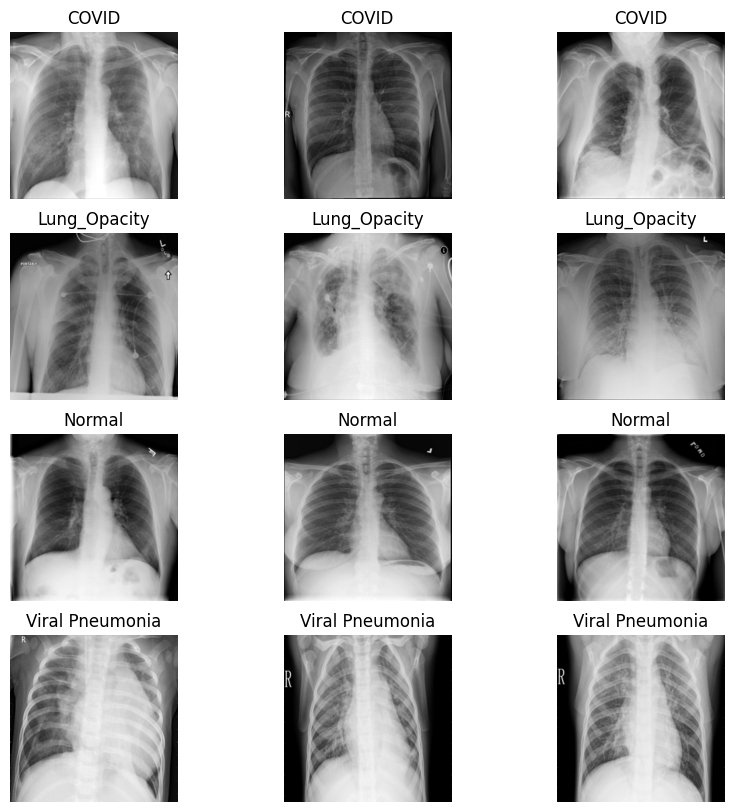

In [24]:
# Initialisation figure
fig = plt.figure(figsize=(10, 10))

# Parcours des sous-dossiers pour afficher trois images aléatoires de chaque dossier
for i, subfolder in enumerate(subfolders):
    # Chemin du sous-dossier contenant les images
    folder_path = folder / subfolder
    
    # Liste des fichiers d'images dans le sous-dossier
    files = list(folder_path.glob("*.png"))
    
    # Choix de trois images aléatoires
    random_images = random.choices(files, k=3)
    
    # Chargement et affichage des trois images dans le sous-graphique correspondant
    for j, image_path in enumerate(random_images):
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        
        # Récupération du nom du dossier parent pour le titre de l'image
        class_name = subfolder.split("/")[0]
        
        # Affichage de l'image dans le sous-graphique correspondant
        plt.subplot(len(subfolders), 3, i * 3 + j + 1)
        plt.imshow(image, cmap="gray")
        plt.title(class_name)
        plt.axis("off")

plt.show();

## Répartition des images par classe

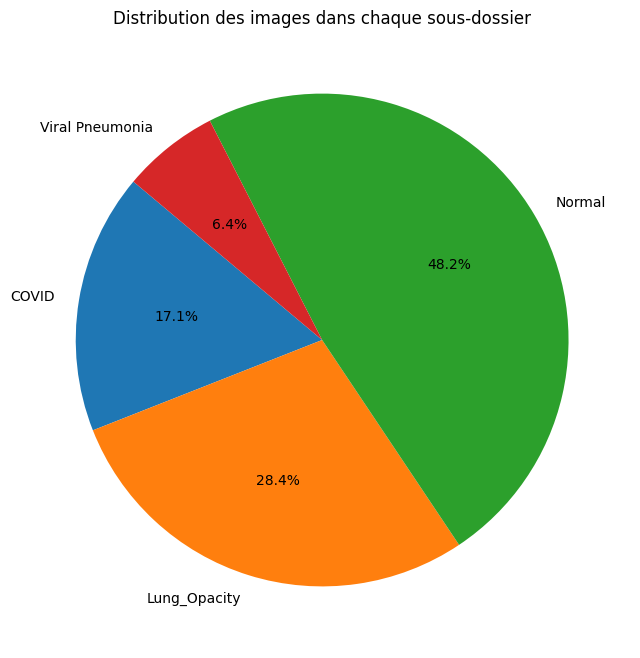

In [25]:
# Liste pour stocker le décompte des images dans chaque sous-dossier
image_counts = []

# Parcours des sous-dossiers et compte du nombre d'images dans chacun
for subfolder in subfolders:
    # Chemin du sous-dossier contenant les images
    folder_path = folder / subfolder

    # Liste des fichiers d'images dans le sous-dossier
    files = list(folder_path.glob("*.png"))

    # Compte des images
    image_count = len(files)

    # Ajout à la liste
    image_counts.append(image_count)

# Liste des noms des sous-dossiers pour le pie plot
labels = [subfolder.split("/")[0] for subfolder in subfolders]

# Initialisation figure
plt.figure(figsize=(8, 8))

# Pie plot
plt.pie(image_counts,
        labels=labels,
        autopct='%1.1f%%',
        startangle=140)
plt.title("Distribution des images dans chaque sous-dossier")
plt.show();

## Image moyenne

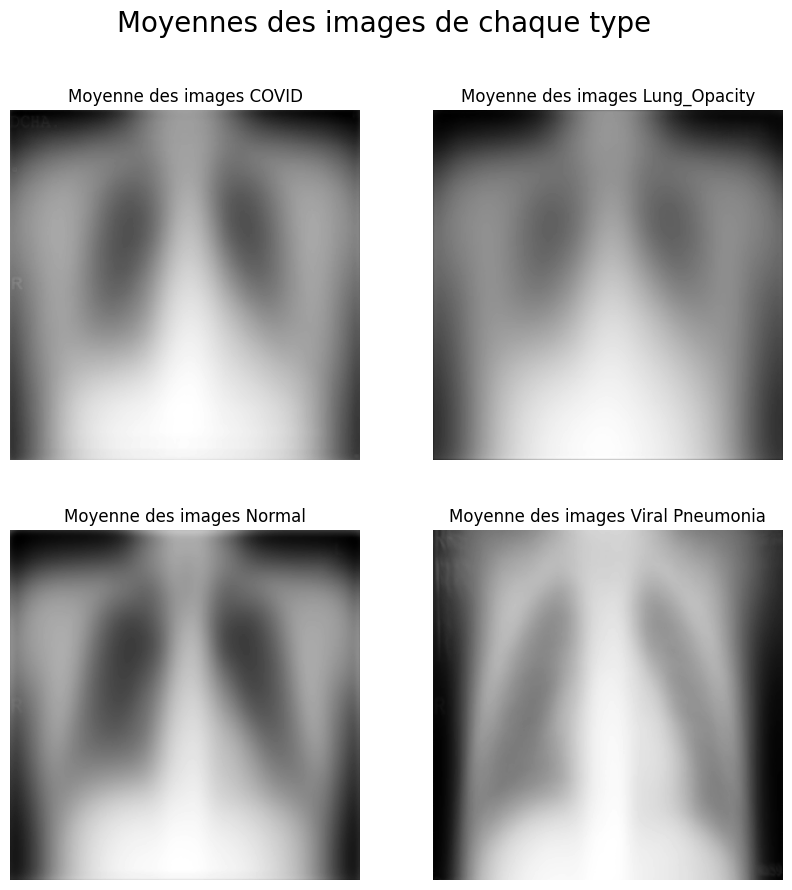

In [3]:
def average_image(file_names, folder_path):
    # Initialisation d'un array NumPy rempli de 0 de la même dimension que l'image
    img_avg = np.zeros((299, 299), dtype=np.float64)

    # Parcours chaque fichier dans la liste
    for name in file_names:
        path = folder_path / name
        img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)
        img_avg += img.astype(np.float64)  # Somme des images

    # Division de la somme des images par le nombre total d'images pour obtenir la moyenne
    img_avg /= len(file_names)  

    return img_avg  # Renvoie l'image moyenne calculée


# Instanciation de la figure
plt.figure(figsize=(10, 10))

# Calcule et affichage de l'image moyenne pour chaque sous-dossier
for i, subfolder in enumerate(subfolders):
    full_subfolder_path = folder / subfolder
    file_names = [file.name for file in full_subfolder_path.iterdir() if file.is_file()]
    avg_img = average_image(file_names, full_subfolder_path)

    # Affichage de l'image moyenne dans la sous-figure correspondante
    plt.subplot(2, 2, i+1)
    plt.imshow(avg_img.astype(np.uint8), cmap="gray")
    plt.title("Moyenne des images " + subfolder.split("/")[0])
    plt.axis("off")

plt.suptitle("Moyennes des images de chaque type", fontsize=20)
plt.show()


## Contraste des images

### Normal vs autres

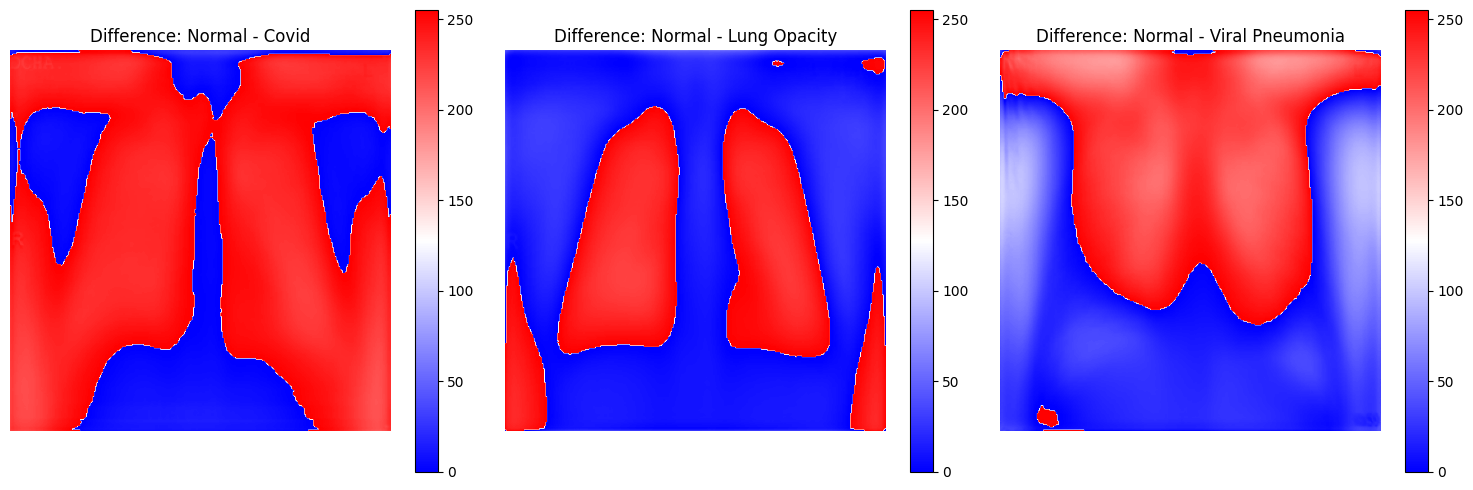

In [12]:
# Initialisation des variables pour stocker les images moyennes
avg_normal = ""
avg_covid = ""
avg_lung = ""
avg_viral = ""

# Calcule et affichage de l'image moyenne pour chaque sous-dossier
for i, subfolder in enumerate(subfolders):
    full_subfolder_path = folder / subfolder
    file_names =  [file.name for file in full_subfolder_path.iterdir() if file.is_file()]
    avg_img = average_image(file_names, full_subfolder_path)

    # Assigne l'image moyenne aux variables correspondantes
    if subfolder == "Normal/images":
        avg_normal = avg_img
    elif subfolder == "COVID/images":
        avg_covid = avg_img
    elif subfolder == "Lung_Opacity/images":
        avg_lung = avg_img
    elif subfolder == "Viral Pneumonia/images":
        avg_viral = avg_img

# Soustraction pour obtenir le contraste
diff_norm_cov = avg_normal - avg_covid
diff_norm_lung = avg_normal - avg_lung
diff_norm_viral = avg_normal - avg_viral

# Affichage des constrastes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot pour 'Normal' - 'Covid'
im0 = axs[0].imshow(diff_norm_cov.astype(np.uint8), cmap="bwr")
axs[0].set_title("Difference: Normal - Covid")
axs[0].axis("off")
cbar0 = plt.colorbar(im0, ax=axs[0], orientation="vertical")

# Plot pour 'Normal' - 'Lung'
im1 = axs[1].imshow(diff_norm_lung.astype(np.uint8), cmap="bwr")
axs[1].set_title("Difference: Normal - Lung Opacity")
axs[1].axis("off")
cbar1 = plt.colorbar(im1, ax=axs[1], orientation="vertical")

# Plot pour 'Normal' - 'Viral'
im2 = axs[2].imshow(diff_norm_viral.astype(np.uint8), cmap="bwr")
axs[2].set_title("Difference: Normal - Viral Pneumonia")
axs[2].axis("off")
cbar2 = plt.colorbar(im2, ax=axs[2], orientation="vertical")

plt.tight_layout()

plt.show();

### Covid vs autres

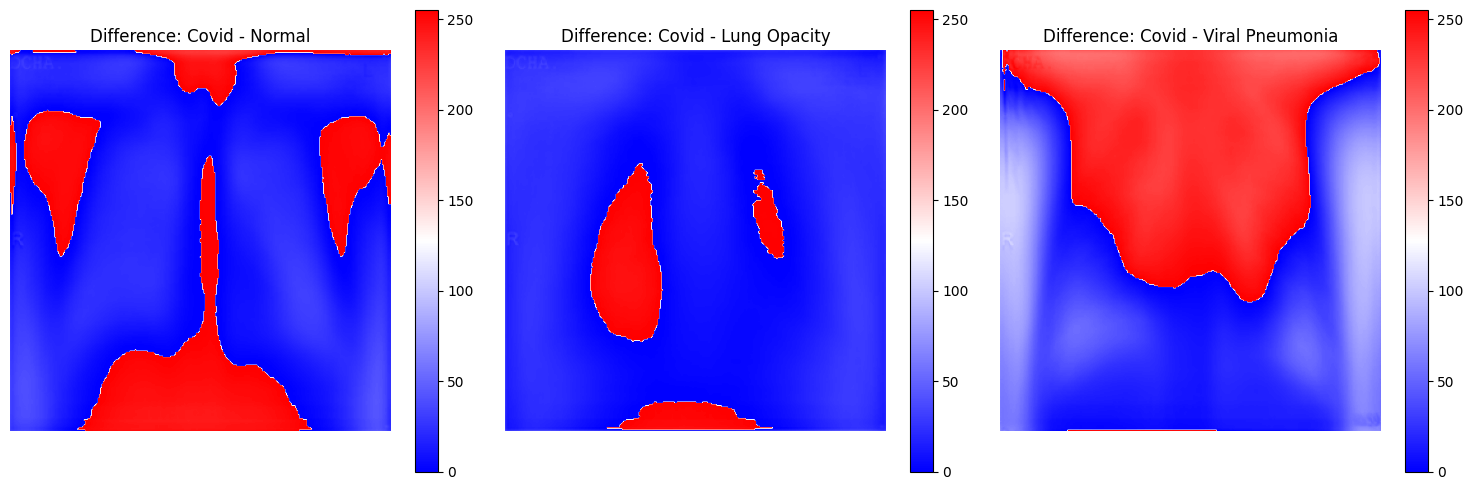

In [13]:
# Initialisation des variables pour stocker les images moyennes
avg_normal = ""
avg_covid = ""
avg_lung = ""
avg_viral = ""

# Calcule et affichage de l'image moyenne pour chaque sous-dossier
for i, subfolder in enumerate(subfolders):
    full_subfolder_path = folder / subfolder
    file_names =  [file.name for file in full_subfolder_path.iterdir() if file.is_file()]
    avg_img = average_image(file_names, full_subfolder_path)

    # Assigne l'image moyenne aux variables correspondantes
    if subfolder == "Normal/images":
        avg_normal = avg_img
    elif subfolder == "COVID/images":
        avg_covid = avg_img
    elif subfolder == "Lung_Opacity/images":
        avg_lung = avg_img
    elif subfolder == "Viral Pneumonia/images":
        avg_viral = avg_img

# Soustraction pour obtenir le contraste
diff_cov_norm = avg_covid - avg_normal
diff_cov_lung = avg_covid - avg_lung
diff_cov_viral = avg_covid - avg_viral

# Affichage des constrastes
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot pour 'Covid' - 'Normal'
im0 = axs[0].imshow(diff_cov_norm.astype(np.uint8), cmap="bwr")
axs[0].set_title("Difference: Covid - Normal")
axs[0].axis("off")
cbar0 = plt.colorbar(im0, ax=axs[0], orientation="vertical")

# Plot pour 'Covid' - 'Lung'
im1 = axs[1].imshow(diff_cov_lung.astype(np.uint8), cmap="bwr")
axs[1].set_title("Difference: Covid - Lung Opacity")
axs[1].axis("off")
cbar1 = plt.colorbar(im1, ax=axs[1], orientation="vertical")

# Plot pour 'Covid' - 'Viral'
im2 = axs[2].imshow(diff_cov_viral.astype(np.uint8), cmap="bwr")
axs[2].set_title("Difference: Covid - Viral Pneumonia")
axs[2].axis("off")
cbar2 = plt.colorbar(im2, ax=axs[2], orientation="vertical")

plt.tight_layout()

plt.show();

## Distribution moyenne des pixels par classe

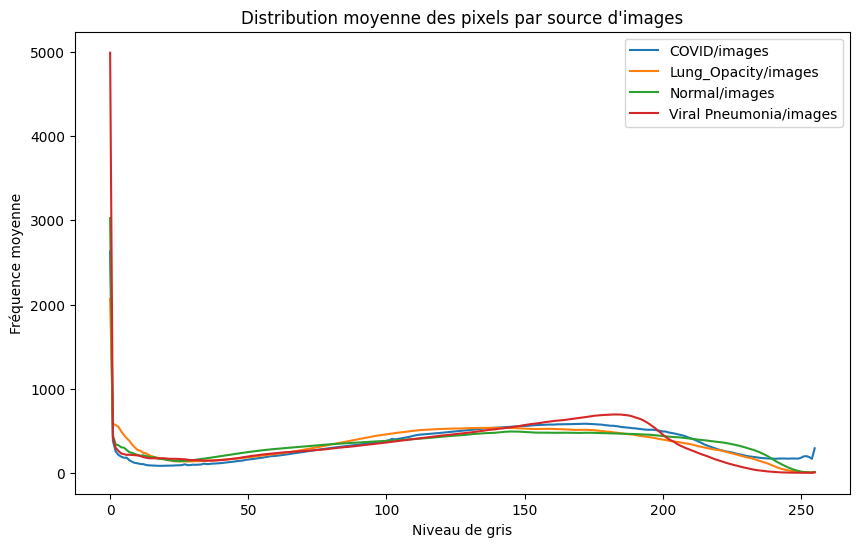

In [30]:
# Fonction pour calculer la distribution moyenne des pixels pour un dossier d'images
def calculate_average_pixel_distribution(image_folder):
    image_paths = list(image_folder.glob("*.png"))
    total_pixels = np.zeros(256)  # Images en échelle de gris

    for image_path in image_paths:
        image = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
        pixels = image.flatten()
        pixel_counts = np.bincount(pixels, minlength=256)
        total_pixels += pixel_counts

    average_pixel_distribution = total_pixels / len(image_paths)
    return average_pixel_distribution

# Liste pour stocker les distributions moyennes des pixels pour chaque sous-dossier
average_distributions_list = []

# Calcule de la distribution moyenne des pixels pour chaque sous-dossier
for subfolder in subfolders:
    image_folder = folder / subfolder
    if image_folder.exists():
        average_distribution = calculate_average_pixel_distribution(image_folder)
        average_distributions_list.append(average_distribution)
    else:
        print(f"Le dossier {subfolder} n'existe pas.")

# Affichage des distributions moyennes des pixels
plt.figure(figsize=(10, 6))

for i, subfolder in enumerate(subfolders):
    plt.plot(average_distributions_list[i], label=subfolder)

plt.xlabel("Niveau de gris")
plt.ylabel("Fréquence moyenne")
plt.title("Distribution moyenne des pixels par source d'images")
plt.legend()

plt.show();


# Il faut avoir la même intensité sur tous les fournisseurs d'images